<a href="https://colab.research.google.com/github/Akash-Rayhan/Resume-Filtering-System/blob/main/notebooks/LSTM_model_bert_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 40.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tens

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import pickle
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
dataframe = pd.read_csv('/content/drive/MyDrive/Datasets/resume_dataset/Resume/Resume.csv')
dataframe.drop(columns = ['ID', 'Resume_html'], inplace = True)
dataframe.head()

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


In [5]:
stop_words = stopwords.words('english')
# stemmer = nltk.SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    '''Make text lowercase,remove extra whitespaces, remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\s+', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))

    return text

In [6]:
dataframe['Resume_str'] = dataframe['Resume_str'].apply(preprocess_data)

In [7]:
le = LabelEncoder()
le.fit(dataframe['Category'])
dataframe['Category'] = le.transform(dataframe['Category'])

In [8]:
features = dataframe['Resume_str'].values
targets = dataframe['Category'].values

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features,targets,random_state=42, test_size=0.2,
                                                 shuffle=True, stratify=targets)

In [9]:
# Load BERT and the preprocessing model from TF Hub.
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2",trainable=True)

In [10]:
feature_input = Input(shape=(), dtype="string", name="word_features")
# Use BERT on a batch of raw text inputs.
input = preprocessor(feature_input)
desc_embedding = encoder(input)["sequence_output"]
lstm_layer = Bidirectional(LSTM(units=64))(desc_embedding)
dense_layer = Dense(64, activation="relu", name="dense_layer")(lstm_layer)
drop_out = Dropout(0.5)(dense_layer)
output = Dense(24,activation="softmax",name="softmax")(drop_out)
model = Model(inputs=feature_input, outputs=output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_features (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['word_features[0][0]']          
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

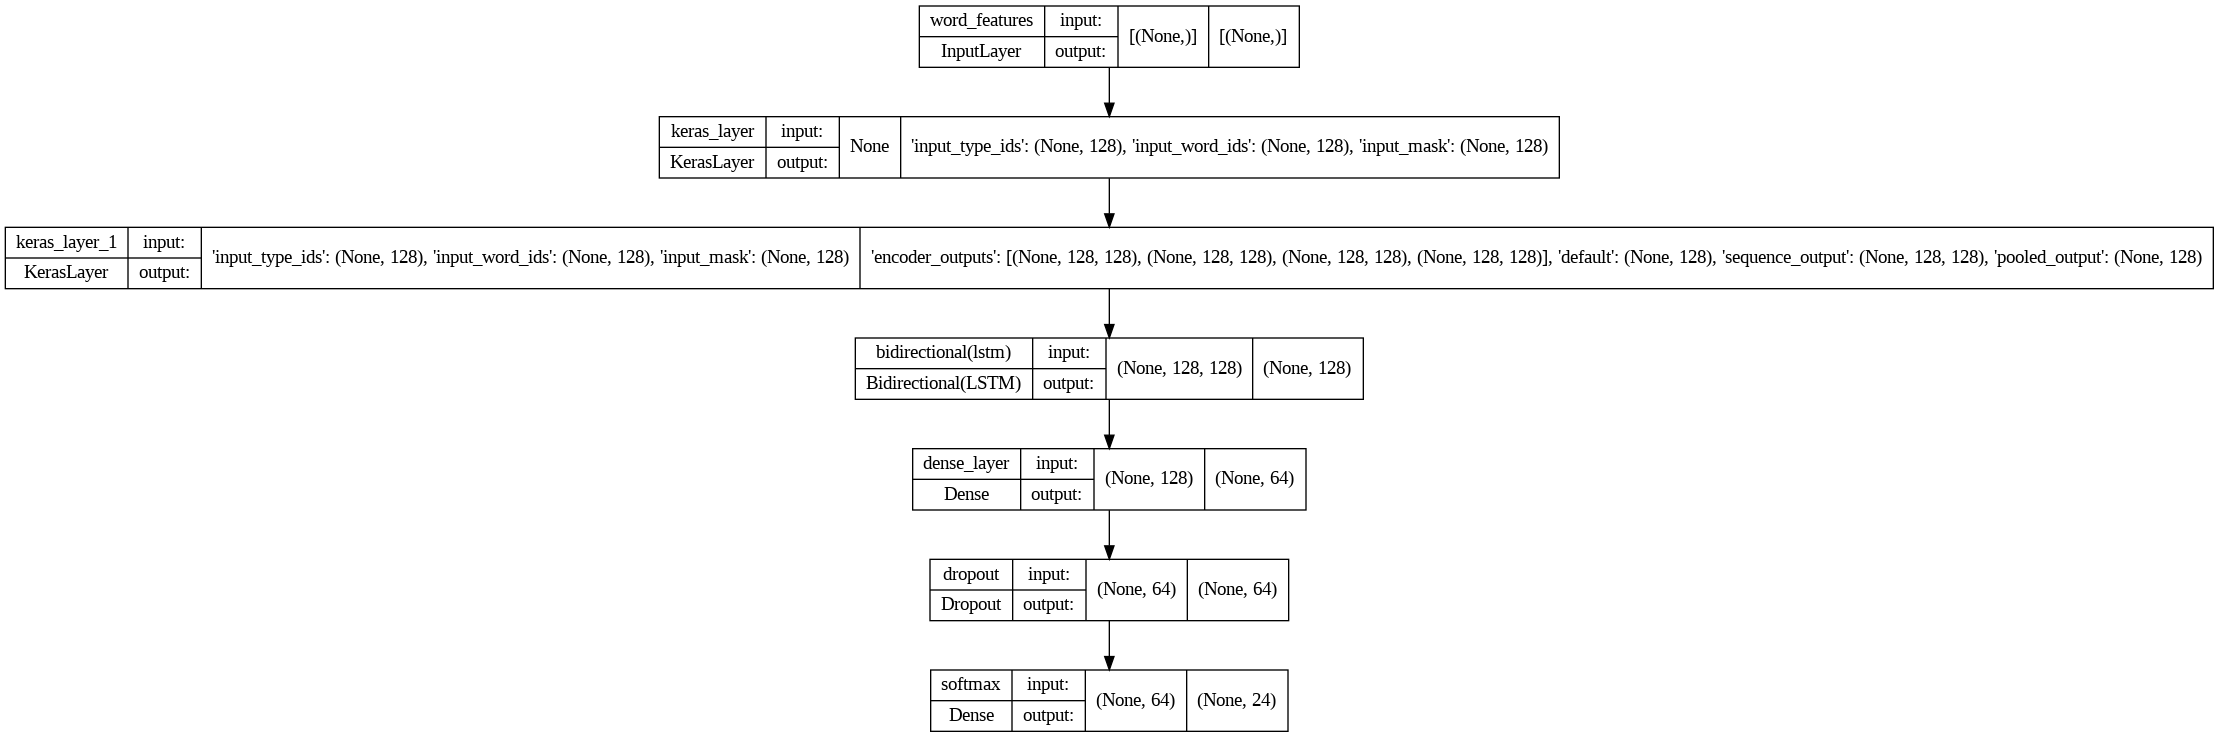

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy'],
)

In [14]:
kfold = KFold(n_splits=5, shuffle=True,random_state=2)

val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model train & evaluation
fold_no = 1
for train, valid in kfold.split(X_train, y_train):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(X_train[train], y_train[train], batch_size=64,
                        epochs=4, validation_data=(X_train[valid], y_train[valid]))
    val_acc_per_fold.append(history.history['val_sparse_categorical_accuracy'])
    acc_per_fold.append(history.history['sparse_categorical_accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/4
25/25 [==============================] - 27s 545ms/step - loss: 3.1797 - sparse_categorical_accuracy: 0.0598 - val_loss: 3.1290 - val_sparse_categorical_accuracy: 0.0955
Epoch 2/4
25/25 [==============================] - 12s 500ms/step - loss: 3.1136 - sparse_categorical_accuracy: 0.0856 - val_loss: 3.0506 - val_sparse_categorical_accuracy: 0.1658
Epoch 3/4
25/25 [==============================] - 13s 542ms/step - loss: 3.0139 - sparse_categorical_accuracy: 0.1410 - val_loss: 2.8780 - val_sparse_categorical_accuracy: 0.3065
Epoch 4/4
25/25 [==============================] - 11s 418ms/step - loss: 2.8075 - sparse_categorical_accuracy: 0.2486 - val_loss: 2.5461 - val_sparse_categorical_accuracy: 0.4799
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/4
25/25 [==============================] - 12s 500ms/step - loss: 2.5054 - spa

In [15]:
predict = np.argmax(model.predict(X_test),axis=1)
print('Test Data accuracy: ',accuracy_score(y_test, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(y_test, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(y_test, predict, target_names=le.classes_))

Test Data accuracy:  77.06237424547284

Confusion Matrix : 
[[24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  6  1  0  0  3  1  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  5  1  0  2  1  0  0  0  0  0  3  3  0  0  2  0  0  0  0  1  1]
 [ 0  0  0  1 12  0  1  0  0  0  0  0  1  0  0  0  0  0  1  0  0  2  1  2]
 [ 0  0  0  1  0  0  3  1  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  2  2  0 14  2  0  0  0  0  0  0  1  1  0  2  0  0  0  0  0  0]
 [ 0  2  0  1  0  0  4 15  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  2  0  0  0 19  0  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 22

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


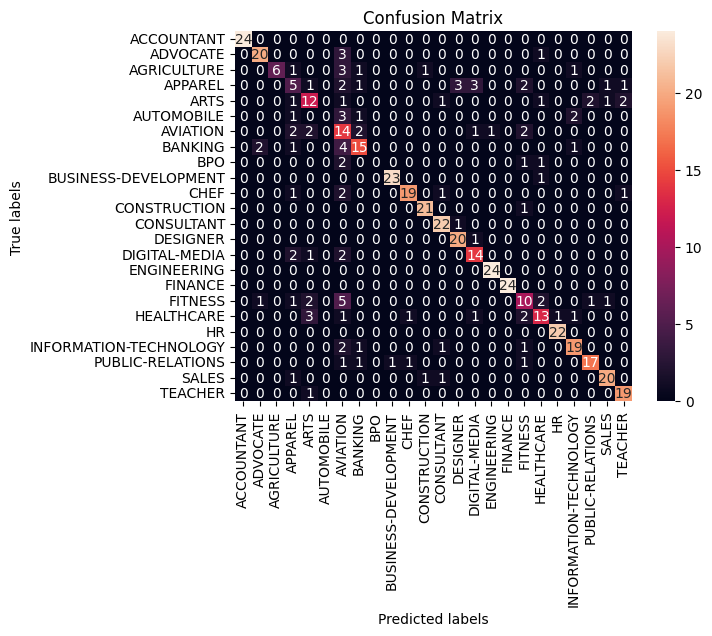

In [16]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(le.classes_); ax.yaxis.set_ticklabels(le.classes_);

In [20]:
model.save('/content/drive/MyDrive/Datasets/LSTM_model_bert.h5')

In [3]:
# Define the custom layers from TF Hub
custom_objects = {
    'KerasLayer': hub.KerasLayer
}

# Load the model with custom layers
model = load_model('/content/drive/MyDrive/Datasets/LSTM_model_bert.h5', custom_objects=custom_objects)

In [10]:
predict = np.argmax(model.predict(X_test),axis=1)
print('Test Data accuracy: ',accuracy_score(y_test, predict)*100)

Test Data accuracy:  77.06237424547284


In [13]:
pickle.dump(le, open("/content/drive/MyDrive/Datasets/variables.p", "wb"))